<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
response

<Response [200]>

In [4]:
# json文字列をdictへ
j_res = json.loads(response.text)
j_res.keys()

dict_keys(['contacts', 'querents', 'patients', 'patients_summary', 'discharges_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])

In [5]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [6]:
keys = ['contacts', 'querents', 'patients_summary', 'discharges_summary']

In [7]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,discharges_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,0,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,0,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...,...
2020-09-10 17:00:00+09:00,601,1771,276,0,2020-09-10 17:00:00+09:00
2020-09-11 17:00:00+09:00,604,1987,187,0,2020-09-11 17:00:00+09:00
2020-09-12 17:00:00+09:00,824,1462,226,0,2020-09-12 17:00:00+09:00
2020-09-13 17:00:00+09:00,585,1297,146,0,2020-09-13 17:00:00+09:00


In [8]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,discharges_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,discharges_7d_mov_ave,discharges_7d_mov_sum
2020-09-10 17:00:00+09:00,601,1771,276,0,2020-09-10 17:00:00+09:00,677.285714,4741.0,1756.428571,12295.0,157.857143,1105.0,0.0,0.0
2020-09-11 17:00:00+09:00,604,1987,187,0,2020-09-11 17:00:00+09:00,670.428571,4693.0,1750.714286,12255.0,165.142857,1156.0,0.0,0.0
2020-09-12 17:00:00+09:00,824,1462,226,0,2020-09-12 17:00:00+09:00,670.428571,4693.0,1760.571429,12324.0,171.571429,1201.0,0.0,0.0
2020-09-13 17:00:00+09:00,585,1297,146,0,2020-09-13 17:00:00+09:00,660.142857,4621.0,1756.285714,12294.0,175.857143,1231.0,0.0,0.0
2020-09-14 17:00:00+09:00,0,0,80,0,2020-09-14 17:00:00+09:00,546.000000,3822.0,1426.000000,9982.0,176.285714,1234.0,0.0,0.0


In [9]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,discharges_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,discharges_7d_mov_ave,discharges_7d_mov_sum,week_num,week_day
2020-08-31 17:00:00+09:00,785,2701,100,0,2020-08-31 17:00:00+09:00,721.142857,5048.0,1963.714286,13746.0,198.428571,1389.0,0.0,0.0,'20w36,Mon
2020-09-01 17:00:00+09:00,650,1813,170,0,2020-09-01 17:00:00+09:00,724.571429,5072.0,1958.428571,13709.0,196.714286,1377.0,0.0,0.0,'20w36,Tue
2020-09-02 17:00:00+09:00,710,1963,141,0,2020-09-02 17:00:00+09:00,729.000000,5103.0,1940.000000,13580.0,183.142857,1282.0,0.0,0.0,'20w36,Wed
2020-09-03 17:00:00+09:00,709,1987,211,0,2020-09-03 17:00:00+09:00,729.142857,5104.0,1916.857143,13418.0,177.571429,1243.0,0.0,0.0,'20w36,Thu
2020-09-04 17:00:00+09:00,652,2027,136,0,2020-09-04 17:00:00+09:00,729.428571,5106.0,1895.142857,13266.0,164.714286,1153.0,0.0,0.0,'20w36,Fri
2020-09-05 17:00:00+09:00,824,1393,181,0,2020-09-05 17:00:00+09:00,727.714286,5094.0,1902.142857,13315.0,155.285714,1087.0,0.0,0.0,'20w36,Sat
2020-09-06 17:00:00+09:00,657,1327,116,0,2020-09-06 17:00:00+09:00,712.428571,4987.0,1887.285714,13211.0,150.714286,1055.0,0.0,0.0,'20w36,Sun
2020-09-07 17:00:00+09:00,799,2312,77,0,2020-09-07 17:00:00+09:00,714.428571,5001.0,1831.714286,12822.0,147.428571,1032.0,0.0,0.0,'20w37,Mon
2020-09-08 17:00:00+09:00,603,1704,170,0,2020-09-08 17:00:00+09:00,707.714286,4954.0,1816.142857,12713.0,147.428571,1032.0,0.0,0.0,'20w37,Tue
2020-09-09 17:00:00+09:00,605,1761,149,0,2020-09-09 17:00:00+09:00,692.714286,4849.0,1787.285714,12511.0,148.571429,1040.0,0.0,0.0,'20w37,Wed


In [10]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [11]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2020-08-23 17:00:00+09:00,231.285714,1619
2020-08-30 17:00:00+09:00,197.714286,1384
2020-09-06 17:00:00+09:00,150.714286,1055
2020-09-13 17:00:00+09:00,175.857143,1231
2020-09-14 17:00:00+09:00,80.000000,80


In [12]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,discharges_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,discharges_7d_mov_ave,discharges_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2020-08-31 17:00:00+09:00,785,2701,100,0,2020-08-31 17:00:00+09:00,721.142857,5048.0,1963.714286,13746.0,198.428571,1389.0,0.0,0.0,'20w36,Mon,NaN,NaN
2020-09-01 17:00:00+09:00,650,1813,170,0,2020-09-01 17:00:00+09:00,724.571429,5072.0,1958.428571,13709.0,196.714286,1377.0,0.0,0.0,'20w36,Tue,NaN,NaN
2020-09-02 17:00:00+09:00,710,1963,141,0,2020-09-02 17:00:00+09:00,729.000000,5103.0,1940.000000,13580.0,183.142857,1282.0,0.0,0.0,'20w36,Wed,NaN,NaN
2020-09-03 17:00:00+09:00,709,1987,211,0,2020-09-03 17:00:00+09:00,729.142857,5104.0,1916.857143,13418.0,177.571429,1243.0,0.0,0.0,'20w36,Thu,NaN,NaN
2020-09-04 17:00:00+09:00,652,2027,136,0,2020-09-04 17:00:00+09:00,729.428571,5106.0,1895.142857,13266.0,164.714286,1153.0,0.0,0.0,'20w36,Fri,NaN,NaN
2020-09-05 17:00:00+09:00,824,1393,181,0,2020-09-05 17:00:00+09:00,727.714286,5094.0,1902.142857,13315.0,155.285714,1087.0,0.0,0.0,'20w36,Sat,NaN,NaN
2020-09-06 17:00:00+09:00,657,1327,116,0,2020-09-06 17:00:00+09:00,712.428571,4987.0,1887.285714,13211.0,150.714286,1055.0,0.0,0.0,'20w36,Sun,150.714286,1055.0
2020-09-07 17:00:00+09:00,799,2312,77,0,2020-09-07 17:00:00+09:00,714.428571,5001.0,1831.714286,12822.0,147.428571,1032.0,0.0,0.0,'20w37,Mon,NaN,NaN
2020-09-08 17:00:00+09:00,603,1704,170,0,2020-09-08 17:00:00+09:00,707.714286,4954.0,1816.142857,12713.0,147.428571,1032.0,0.0,0.0,'20w37,Tue,NaN,NaN
2020-09-09 17:00:00+09:00,605,1761,149,0,2020-09-09 17:00:00+09:00,692.714286,4849.0,1787.285714,12511.0,148.571429,1040.0,0.0,0.0,'20w37,Wed,NaN,NaN


### グラフ出力

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
y2_1 = df3['patients_7d_mov_sum']
y2_2 = df3['patients_week_sum']

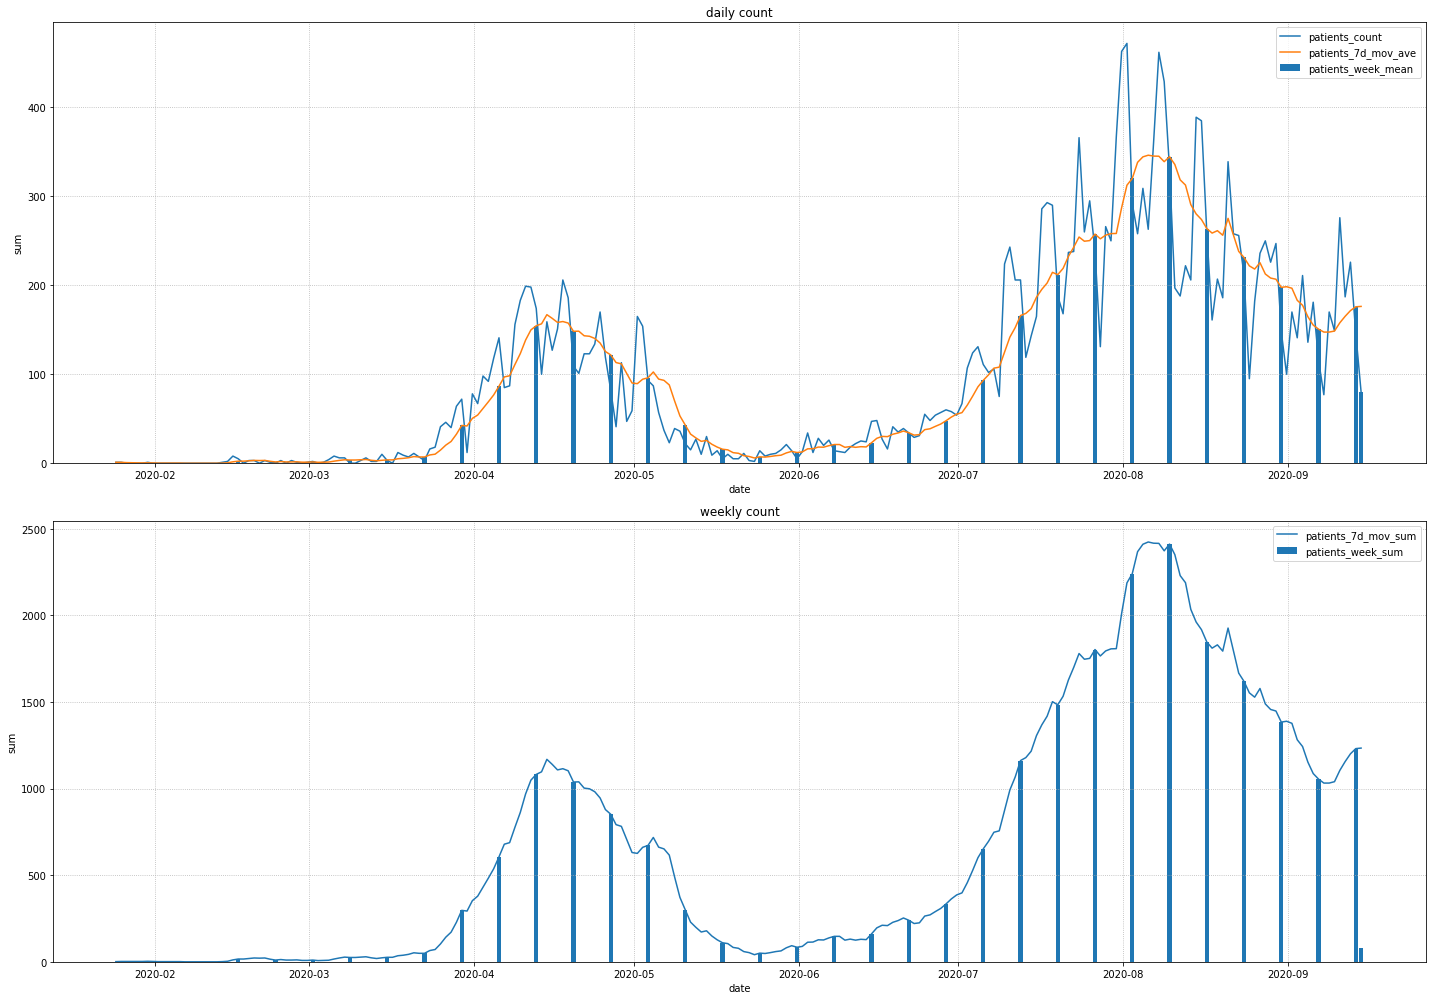

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(20, 14))

### 日毎の数
ax[0].set_title('daily count')
ax[0].set_xlabel('date')
ax[0].set_ylabel('sum')
ax[0].plot(x, y1_1, label='patients_count')
ax[0].plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
ax[0].bar(x, y1_4, label='patients_week_mean')
ax[0].grid(linestyle=':')
ax[0].legend()

### 週毎の合計
ax[1].set_title('weekly count')
ax[1].set_xlabel('date')
ax[1].set_ylabel('sum')
ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
ax[1].bar(x, y2_2, label='patients_week_sum')
ax[1].grid(linestyle=':')
ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum,discharges_count,discharges_7d_mov_ave,discharges_7d_mov_sum
220,1.598861e+09,2020,8,31,0,1,0,0,0,0,0,220,0,146,785,721.142857,5048.0,2701,1963.714286,13746.0,100,198.428571,1389.0,0,0.0,0.0
221,1.598947e+09,2020,9,1,0,0,0,0,0,1,0,221,0,147,650,724.571429,5072.0,1813,1958.428571,13709.0,170,196.714286,1377.0,0,0.0,0.0
222,1.599034e+09,2020,9,2,0,0,0,0,0,0,1,222,0,148,710,729.000000,5103.0,1963,1940.000000,13580.0,141,183.142857,1282.0,0,0.0,0.0
223,1.599120e+09,2020,9,3,0,0,0,0,1,0,0,223,0,149,709,729.142857,5104.0,1987,1916.857143,13418.0,211,177.571429,1243.0,0,0.0,0.0
224,1.599206e+09,2020,9,4,1,0,0,0,0,0,0,224,0,150,652,729.428571,5106.0,2027,1895.142857,13266.0,136,164.714286,1153.0,0,0.0,0.0
225,1.599293e+09,2020,9,5,0,0,1,0,0,0,0,225,0,151,824,727.714286,5094.0,1393,1902.142857,13315.0,181,155.285714,1087.0,0,0.0,0.0
226,1.599379e+09,2020,9,6,0,0,0,1,0,0,0,226,0,152,657,712.428571,4987.0,1327,1887.285714,13211.0,116,150.714286,1055.0,0,0.0,0.0
227,1.599466e+09,2020,9,7,0,1,0,0,0,0,0,227,0,153,799,714.428571,5001.0,2312,1831.714286,12822.0,77,147.428571,1032.0,0,0.0,0.0
228,1.599552e+09,2020,9,8,0,0,0,0,0,1,0,228,0,154,603,707.714286,4954.0,1704,1816.142857,12713.0,170,147.428571,1032.0,0,0.0,0.0
229,1.599638e+09,2020,9,9,0,0,0,0,0,0,1,229,0,155,605,692.714286,4849.0,1761,1787.285714,12511.0,149,148.571429,1040.0,0,0.0,0.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   timestamp              235 non-null    float64
 1   year                   235 non-null    int64  
 2   month                  235 non-null    int64  
 3   day                    235 non-null    int64  
 4   Fri                    235 non-null    uint8  
 5   Mon                    235 non-null    uint8  
 6   Sat                    235 non-null    uint8  
 7   Sun                    235 non-null    uint8  
 8   Thu                    235 non-null    uint8  
 9   Tue                    235 non-null    uint8  
 10  Wed                    235 non-null    uint8  
 11  passed                 235 non-null    int64  
 12  emergency              235 non-null    int64  
 13  em_passed              235 non-null    int64  
 14  contacts_count         235 non-null    int64  
 15  contac

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum,discharges_count,discharges_7d_mov_ave,discharges_7d_mov_sum
count,2.350000e+02,235.0,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.0,235.0,235.0
mean,1.589962e+09,2020.0,5.127660,15.634043,0.144681,0.144681,0.144681,0.144681,0.140426,0.140426,0.140426,117.000000,0.208511,54.808511,853.417021,847.437589,5932.046809,1302.246809,1287.902128,9015.314894,98.225532,96.183161,673.212766,0.0,0.0,0.0
std,5.873717e+06,0.0,2.260938,8.962535,0.352530,0.352530,0.352530,0.352530,0.348170,0.348170,0.348170,67.982841,0.407111,53.598156,516.030589,503.210673,3522.502185,827.869301,637.411772,4461.882406,110.071404,102.231885,715.688352,0.0,0.0,0.0
min,1.579853e+09,2020.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
25%,1.584907e+09,2020.0,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,58.500000,0.000000,0.000000,505.000000,501.785714,3512.500000,646.500000,928.285714,6498.000000,7.500000,7.000000,49.000000,0.0,0.0,0.0
50%,1.589962e+09,2020.0,5.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,117.000000,0.000000,43.000000,718.000000,707.714286,4954.000000,1321.000000,1221.142857,8548.000000,54.000000,50.428571,353.000000,0.0,0.0,0.0
75%,1.595016e+09,2020.0,7.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,175.500000,0.000000,101.500000,1165.500000,1181.071429,8267.500000,1840.000000,1769.285714,12385.000000,169.000000,164.928571,1154.500000,0.0,0.0,0.0
max,1.600070e+09,2020.0,9.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,234.000000,1.000000,160.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,472.000000,346.285714,2424.000000,0.0,0.0,0.0


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum,discharges_count,discharges_7d_mov_ave,discharges_7d_mov_sum
timestamp,1.000000,NaN,0.991549,-0.028069,-0.009094,0.009094,-0.003031,0.003031,0.005958,-0.005958,0.000000e+00,1.000000e+00,-0.143755,0.966787,0.298933,0.360744,0.360748,0.528709,0.737583,0.737583,0.681330,0.740572,0.740670,NaN,NaN,NaN
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,0.991549,NaN,1.000000,-0.157332,-0.012549,0.008898,-0.001825,0.003536,0.004274,-0.006584,4.273745e-03,9.915489e-01,-0.140470,0.957228,0.299620,0.358993,0.358999,0.527719,0.739693,0.739693,0.679689,0.735940,0.736051,NaN,NaN,NaN
day,-0.028069,NaN,-0.157332,1.000000,0.027650,0.000599,-0.010222,-0.003459,0.012430,0.005583,-3.276313e-02,-2.806926e-02,0.003434,-0.025269,-0.013829,-0.000015,-0.000022,-0.030242,-0.071199,-0.071199,-0.052245,-0.036906,-0.037007,NaN,NaN,NaN
Fri,-0.009094,NaN,-0.012549,0.027650,1.000000,-0.169154,-0.169154,-0.169154,-0.166235,-0.166235,-1.662351e-01,-9.094093e-03,-0.002661,-0.005313,-0.017036,-0.008762,-0.008760,0.067234,-0.008834,-0.008834,0.088583,-0.004313,-0.004374,NaN,NaN,NaN
Mon,0.009094,NaN,0.008898,0.000599,-0.169154,1.000000,-0.169154,-0.169154,-0.166235,-0.166235,-1.662351e-01,9.094093e-03,-0.002661,0.010293,0.031381,-0.003913,-0.003911,0.256259,-0.001339,-0.001339,-0.133554,0.003268,0.003282,NaN,NaN,NaN
Sat,-0.003031,NaN,-0.001825,-0.010222,-0.169154,-0.169154,1.000000,-0.169154,-0.166235,-0.166235,-1.662351e-01,-3.031364e-03,-0.002661,-0.000111,0.038170,-0.005927,-0.005925,-0.329427,-0.004862,-0.004862,0.095081,-0.000501,-0.000546,NaN,NaN,NaN
Sun,0.003031,NaN,0.003536,-0.003459,-0.169154,-0.169154,-0.169154,1.000000,-0.166235,-0.166235,-1.662351e-01,3.031364e-03,-0.002661,0.005091,-0.014733,-0.003913,-0.003911,-0.301488,-0.001339,-0.001339,-0.022651,0.001932,0.001927,NaN,NaN,NaN
Thu,0.005958,NaN,0.004274,0.012430,-0.166235,-0.166235,-0.166235,-0.166235,1.000000,-0.163366,-1.633663e-01,5.958103e-03,0.003592,0.001905,0.002265,0.009694,0.009696,0.097599,0.010389,0.010389,0.073548,0.003871,0.003910,NaN,NaN,NaN
Tue,-0.005958,NaN,-0.006584,0.005583,-0.166235,-0.166235,-0.166235,-0.166235,-0.163366,1.000000,-1.633663e-01,-5.958103e-03,0.003592,-0.008629,-0.028965,0.005491,0.005493,0.134309,0.000673,0.000673,-0.045657,-0.003405,-0.003379,NaN,NaN,NaN


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum', 'discharges_count',
       'discharges_7d_mov_ave', 'discharges_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          'discharges_7d_mov_ave', 'discharges_7d_mov_sum'], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum,discharges_count
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0,0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0,0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0,0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0,0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,1.599725e+09,0,0,0,0,1,0,0,230,0,156,601,1771,276,157.857143,1105.0,0
231,1.599811e+09,1,0,0,0,0,0,0,231,0,157,604,1987,187,165.142857,1156.0,0
232,1.599898e+09,0,0,1,0,0,0,0,232,0,158,824,1462,226,171.571429,1201.0,0
233,1.599984e+09,0,0,0,1,0,0,0,233,0,159,585,1297,146,175.857143,1231.0,0


In [26]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


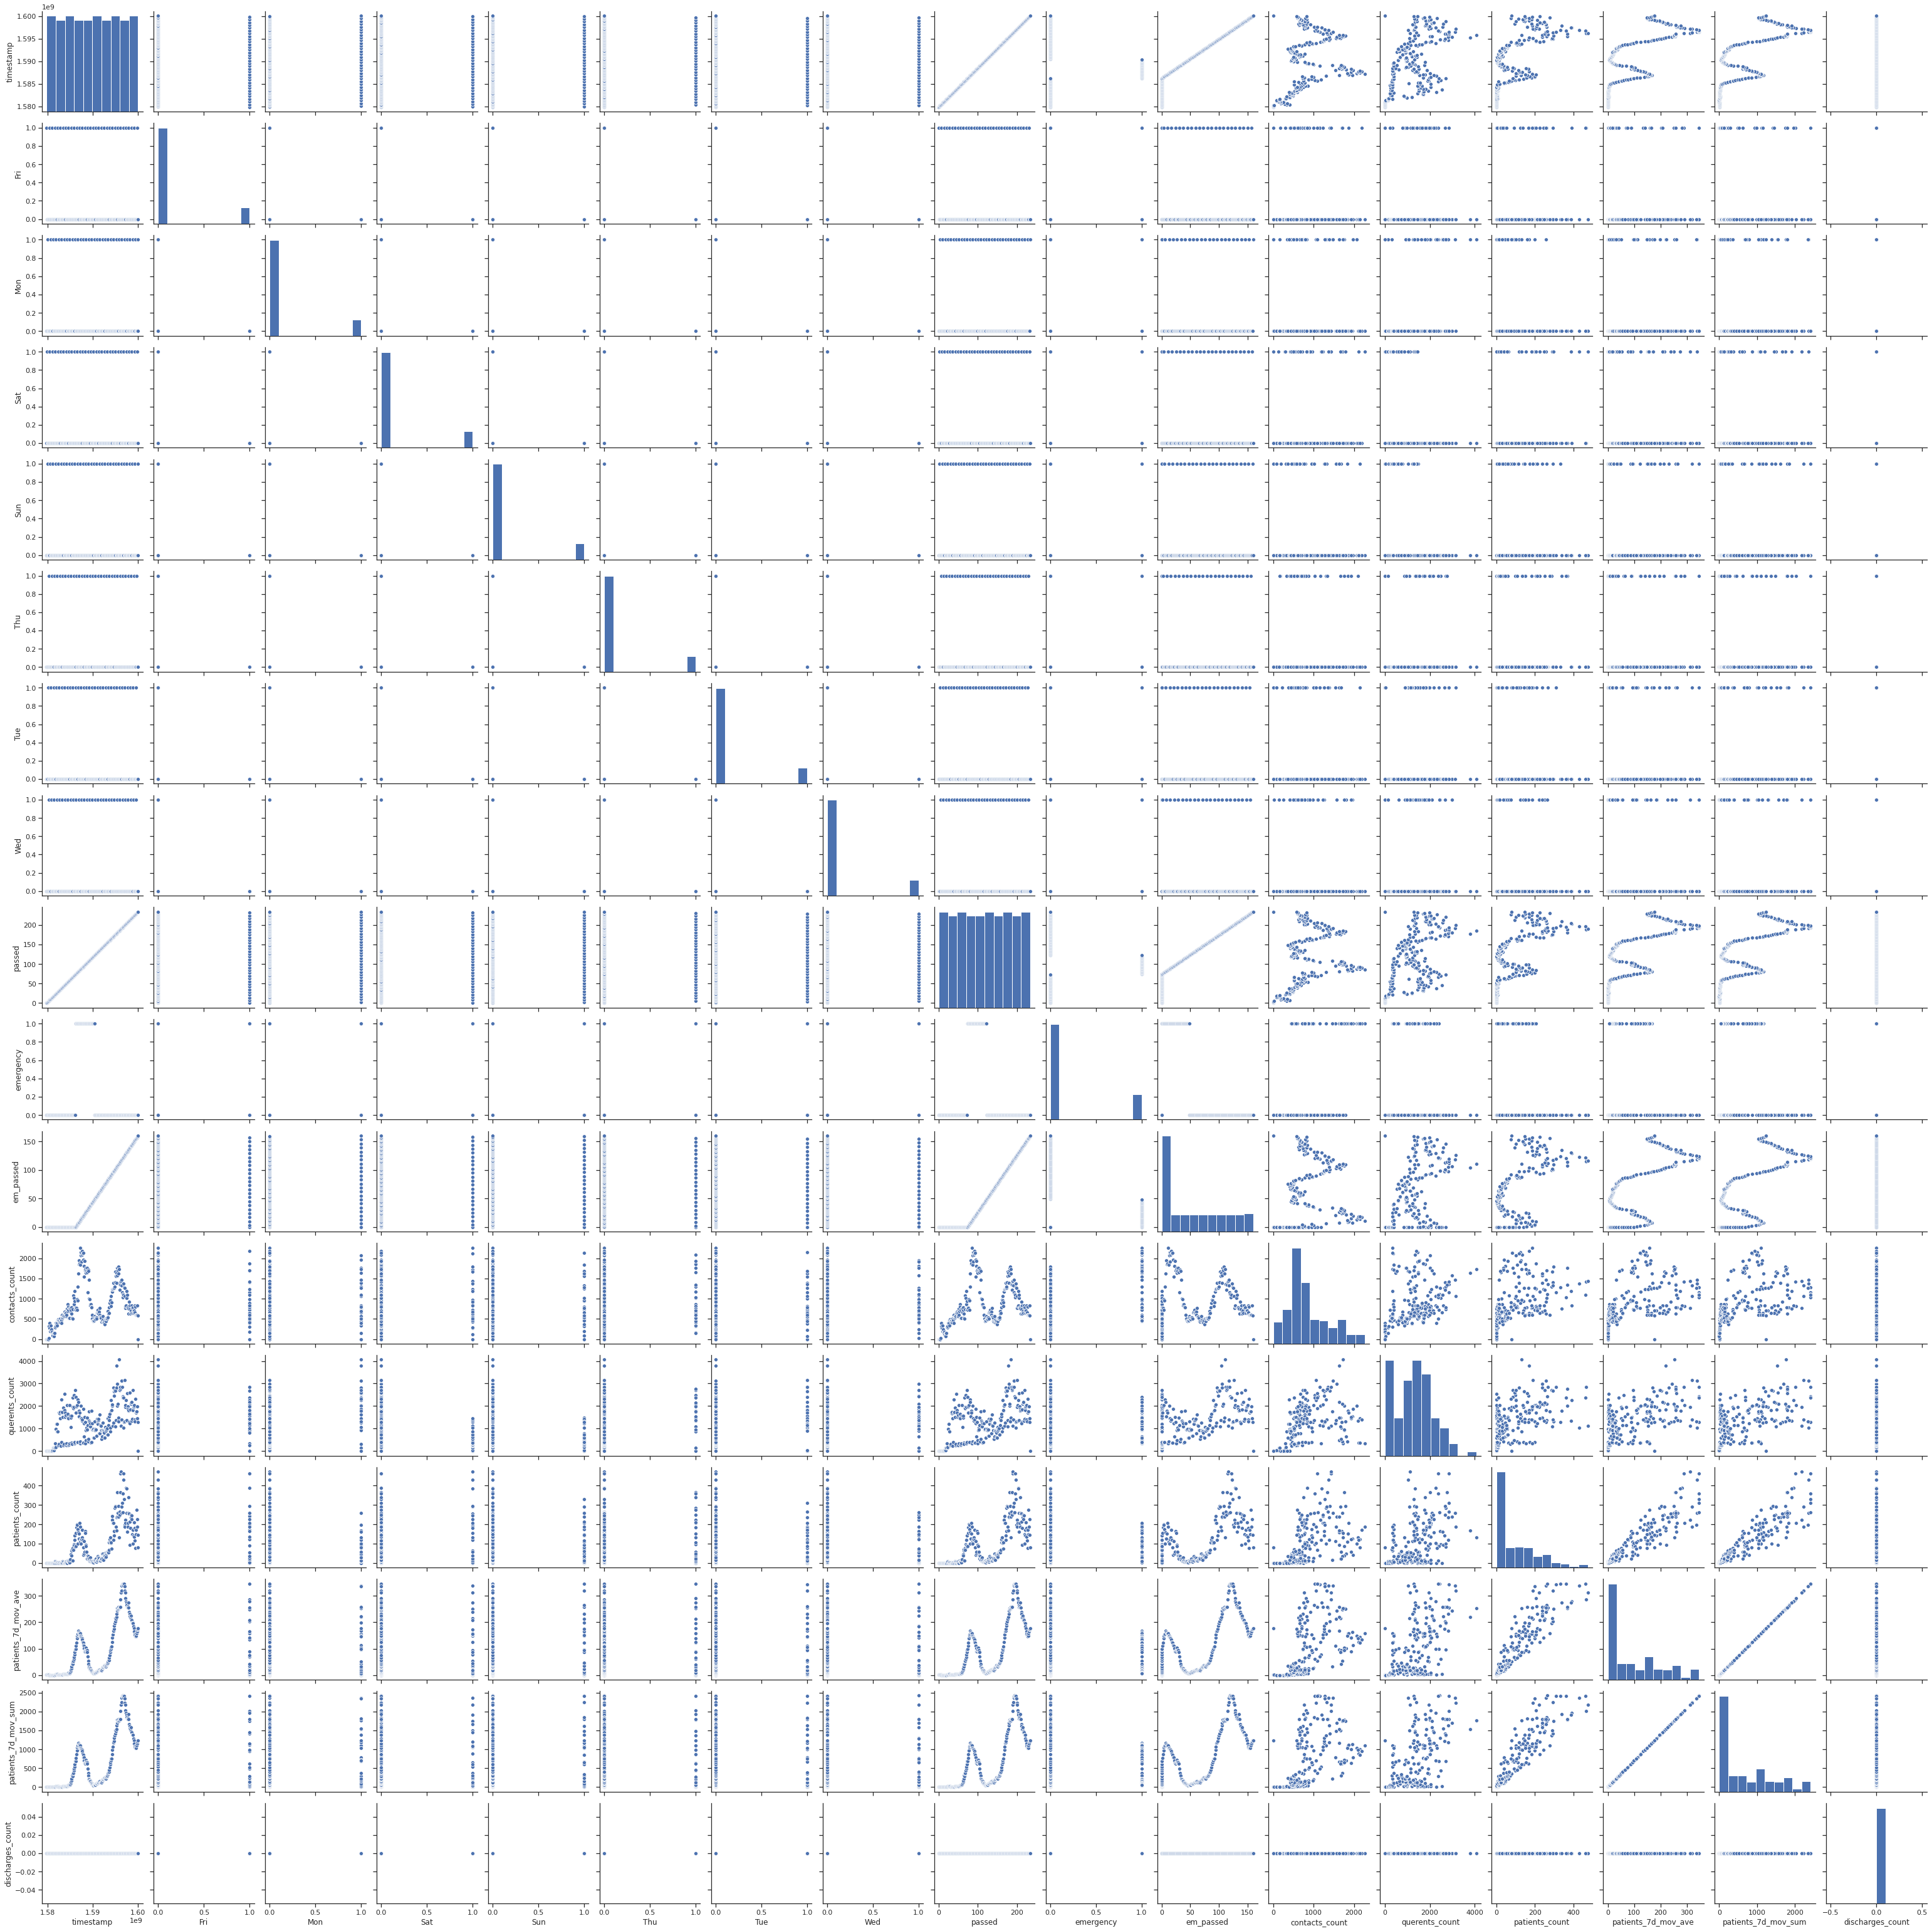

In [27]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(data=_df);

In [ ]:
!python -V

Python 3.6.9
